In [1]:
import defense
import os
import inceptionv3
import numpy as np
import tensorflow as tf
import utils
import albumentations

/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eason/anaconda3/envs/untitled/lib/pyt

In [2]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)

In [3]:
cleandata = np.load("./data/clean100data.npy")
cleanlabel = np.load("./data/clean100label.npy")
targets = np.load("./data/random_targets.npy")

In [4]:
l2_x = tf.placeholder(tf.float32, (None,299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (None,299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

In [5]:
x = tf.placeholder(tf.float32, (None, 299, 299, 3))

session_logits, session_preds = inceptionv3.model(sess, x)
session_l2_x = tf.placeholder(tf.float32, (299, 299, 3))
session_l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
session_normalized_l2_loss = tf.nn.l2_loss(session_l2_orig - session_l2_x) / tf.nn.l2_loss(session_l2_orig)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/eason/Research/Paris/ALL_Defense/data/inception_v3.ckpt


In [8]:
def defended(imgbatch,tran=0.16,scal=0.16,rota=4):
    defbatch = np.zeros_like(imgbatch)
    for i in range(ae_data.shape[0]):
        defbatch[i]=augimg(ae_data[i],tran=tran,scal=scal,rota=rota)
    return defbatch

def augimg(img,tran=0.16,scal=0.16,rota=4):
    aug = albumentations.ShiftScaleRotate(shift_limit=tran,scale_limit=scal,rotate_limit=rota,p=1,border_mode=0)
    augmented = aug(image=img.astype(np.float32))
    auged = augmented['image']
    return auged

In [7]:
def defend_test(img):
    aug = albumentations.ImageCompression(quality_lower=20,quality_upper=80,compression_type=1,p=1)
    augmented = aug(image=(img*255).astype(np.uint8))
    auged = augmented['image']/255
    return auged

In [13]:
def defended(imgbatch):
    defbatch = np.zeros_like(imgbatch)
    for i in range(ae_data.shape[0]):
        defbatch[i]=defense.defend_CROP(ae_data[i])
    return defbatch

In [15]:
totalbatch = 10
batchsize = 10
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
#         ae_FD = defended(ae_data)
        ae_FD = np.copy(ae_data)
        preds = np.zeros((100))
        for numbatch in range(totalbatch):
            aebatch, _ = utils.getabatch(ae_FD, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == targets))

./AE/PGD_AE_data.npy
Accuracy: 0.21
Attack success rate: 0.33


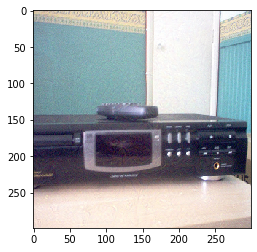

In [21]:
import matplotlib.pyplot as plt
plt.imshow(ae_data[0])

# No defense Accuracy

In [11]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy' and name.find('AE') != -1:
        print(path)
        ae_data = np.load(path)
        preds = np.zeros((100))
#         print("Linf", linf_distortion(ae_data, cleandata))
        l2 = sess.run([normalized_l2_loss], {l2_x: ae_data, l2_orig: cleandata})
        print("L2:", l2)
        for numbatch in range(totalbatch):
            aebatch, _ = utils.getabatch(ae_data, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == targets))

./AE/PGD_AE_Acc.npy
L2: [0.00027422523]
Accuracy: 0.0
Attack success rate: 1.0


In [13]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        ae_FD = defended(ae_data)
        preds = np.zeros((100))
        for numbatch in range(totalbatch):
            aebatch, _ = getabatch(ae_FD, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == targets))

./AE/LBFGS_AE_data.npy
Accuracy: 0.92
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.95
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.92
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.9
Attack success rate: 0.0
./AE/FGSM_003_AE_data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.97
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.94
Attack success rate: 0.0


# FD Accuracy

In [ ]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        ae_FD = defense.defended('SHIELD',ae_data)
        preds = np.zeros((100))
        for numbatch in range(totalbatch):
            aebatch, _ = getabatch(ae_FD, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == targets))

./AE/LBFGS_AE_data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.81
Attack success rate: 0.02
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.87
Attack success rate: 0.01
./AE/FGSM_003_AE_data.npy
Accuracy: 0.49
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy


# GD Accuracy

In [28]:
ds = 0.15
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        ae_GD = np.zeros(ae_data.shape)
        for i in range(ae_data.shape[0]):
            ae_GD[i] = defend_GD(ae_data[i], distort_limit=ds)
        preds = np.zeros((100))
        for numbatch in range(totalbatch):
            aebatch, _ = getabatch(ae_GD, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.56
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.83
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.92
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.66
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.96
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.75
Attack success rate: 0.04
./AE/Deepfool_AE_data.npy
Accuracy: 0.98
Attack success rate: 0.0


# FD+GD Accuracy

In [22]:
ds = 0.25
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        ae_FD_GD = np.zeros(ae_data.shape)
        for i in range(ae_data.shape[0]):
            ae_FD_GD[i] = defend_GD(defend_FD_sig(ae_data[i]), distort_limit = ds)
        preds = np.zeros((100))
        for numbatch in range(totalbatch):
            aebatch, _ = getabatch(ae_FD_GD, cleanlabel, numbatch, batchsize)
            preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.55
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.83
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.75
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.89
Attack success rate: 0.0
./AE/Deepfool_AE_data.npy
Accuracy: 0.94
Attack success rate: 0.0


In [15]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy' and name.find('LBFGS') != -1:
        print(path)
        ae_data = np.load(path)
        for ds in [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]:
            print("Distortion:", ds)
            ae_FD_GD = np.zeros(ae_data.shape)
            for i in range(ae_data.shape[0]):
                ae_FD_GD[i] = defend_GD(defend_FD_sig(ae_data[i]), distort_limit = ds)
            preds = np.zeros((100))
            for numbatch in range(totalbatch):
                aebatch, _ = getabatch(ae_FD_GD, cleanlabel, numbatch, batchsize)
                preds[numbatch*batchsize:(numbatch*batchsize+batchsize)] = sess.run([session_preds], {x: aebatch})[0]
            print("Accuracy:", np.mean(preds == cleanlabel))
            print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/LBFGS_AE_data.npy
Distortion: 0.01
Accuracy: 0.95
Attack success rate: 0.0
Distortion: 0.05
Accuracy: 0.97
Attack success rate: 0.0
Distortion: 0.1
Accuracy: 0.93
Attack success rate: 0.0
Distortion: 0.15
Accuracy: 0.91
Attack success rate: 0.0
Distortion: 0.2
Accuracy: 0.94
Attack success rate: 0.0
Distortion: 0.25
Accuracy: 0.94
Attack success rate: 0.0
Distortion: 0.3
Accuracy: 0.88
Attack success rate: 0.0


# Randomization

In [16]:
x_single = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x_single, axis=0)
rand_xs = defend_randomization(x_expanded)
rand_logits, rand_preds = inceptionv3.model(sess, rand_xs)


Instructions for updating:
box_ind is deprecated, use box_indices instead
INFO:tensorflow:Scale of 0 disables regularizer.


In [24]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        preds = np.zeros((100))
        for i in range(100):
            preds[i] = sess.run([rand_preds], {x_single: ae_data[i]})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.6
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.86
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.92
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.69
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.96
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.86
Attack success rate: 0.01
./AE/Deepfool_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0


# FD+Randomization

In [25]:
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        preds = np.zeros((100))
        for i in range(100):
            preds[i] = sess.run([rand_preds], {x_single: defend_FD_sig(ae_data[i])})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.58
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.86
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.79
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.92
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.88
Attack success rate: 0.0
./AE/Deepfool_AE_data.npy
Accuracy: 0.93
Attack success rate: 0.0


# Randomization parameter test

In [32]:
x_single = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x_single, axis=0)
rand_xs = defend_randomization_test(x_expanded, bound=400, pad_value=1)
rand_logits, rand_preds = inceptionv3.model(sess, rand_xs)

INFO:tensorflow:Scale of 0 disables regularizer.


In [33]:
# Random
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        preds = np.zeros((100))
        for i in range(100):
            preds[i] = sess.run([rand_preds], {x_single: ae_data[i]})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.58
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.86
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.9
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.68
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.95
Attack success rate: 0.0
./AE/LBFGS_AE_data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.84
Attack success rate: 0.01
./AE/Deepfool_AE_data.npy
Accuracy: 0.95
Attack success rate: 0.0


In [34]:
# FD+Random
ae_dir = "./AE"
names = os.listdir(ae_dir)
for name in names:
    path = os.path.join(ae_dir, name)
    if os.path.splitext(path)[-1] == '.npy':
        print(path)
        ae_data = np.load(path)
        preds = np.zeros((100))
        for i in range(100):
            preds[i] = sess.run([rand_preds], {x_single: defend_FD_sig(ae_data[i])})[0]
        print("Accuracy:", np.mean(preds == cleanlabel))
        print("Attack success rate:", np.mean(preds == np.argmax(targets, axis=1)))

./AE/FGSM_003_AE_data.npy
Accuracy: 0.6
Attack success rate: 0.0
./AE/CW_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0
./AE/IFGSM_001_AE_data.npy
Accuracy: 0.91
Attack success rate: 0.0
./AE/FGSM_001_AE_data.npy
Accuracy: 0.75
Attack success rate: 0.0
./AE/clean100data.npy
Accuracy: 0.93
Attack success rate: 0.0
./AE/LBFGS_AE_data.npy
Accuracy: 0.87
Attack success rate: 0.0
./AE/IFGSM_003_AE_data.npy
Accuracy: 0.83
Attack success rate: 0.0
./AE/Deepfool_AE_data.npy
Accuracy: 0.93
Attack success rate: 0.0
